In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk

from nltk.corpus import stopwords 
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20.0, 10.0)s
plt.rcParams.update({'font.size': 22})
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Background

I'm going to perform a sentiment analysis on the video games from Amazon. Instead of filling in keywords to develop the sentiment, I'm going to use the ratings instead and change it from an ordinal variable to a categorical variable of true or false. I will use the bag of words approach to create classification model. The link can be found here: http://jmcauley.ucsd.edu/data/amazon/

In [2]:
game_reviews = pd.read_json('reviews_Video_Games_5.json', lines=True)

In [3]:
# Look at what kind of data I'm looking at.
game_reviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


In [4]:
# Making sure I can use the data here.
game_reviews.dtypes

asin              object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

In [5]:
# Take a look at the size of my data
game_reviews.shape

(231780, 9)

In [4]:
# If reviews >3, then good, otherwise bad.
game_reviews['overall_cat'] = game_reviews['overall'].map(lambda i:1 if i>3 else 0)

In [7]:
game_reviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall_cat
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000,0
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400,1
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600,0
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400,0
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,1


In [5]:
# Check to see if there is a class imbalance between good and bad reviews.
game_reviews.overall_cat.value_counts()

1    174989
0     56791
Name: overall_cat, dtype: int64

In [6]:
# There are actually more good reviews than bad reviews, what a surprise.
# Balance the data. 
# Use downsampling of the minority class to address the class imbalance. 
from sklearn.utils import resample

# Separate the majority and minority Class.
gr_majority = game_reviews[game_reviews.overall_cat==1]
gr_minority = game_reviews[game_reviews.overall_cat==0]


# Downsample majority class 
gr_maj_downsampled = resample(gr_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(gr_minority))    # to match minority class
                                
# Combine minority class with downsampled majority class
gr_downsampled = pd.concat([gr_maj_downsampled, gr_minority])


In [8]:
# Look at the size of our data now.
gr_downsampled.shape

(113582, 10)

In [11]:
gr_downsampled.describe()

,overall,unixReviewTime,overall_cat
count,113582.000000,1.135820e+05,113582.000000
mean,3.461033,1.275163e+09,0.500000
std,1.399793,1.148183e+08,0.500002
min,1.000000,9.398592e+08,0.000000
25%,2.000000,1.211155e+09,0.000000
50%,3.500000,1.312675e+09,0.500000
75%,5.000000,1.366330e+09,1.000000
max,5.000000,1.405987e+09,1.000000


In [7]:
# In an attempt to make .describe more useful, lets quantify reviews and summary 
# by word length
gr_downsampled['review_length'] = gr_downsampled['reviewText'].apply(len)
gr_downsampled['summary_length'] = gr_downsampled['summary'].apply(len)

# Take a look at what the dataset looks like now.
gr_downsampled.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall_cat,review_length,summary_length
179458,B00503E8S2,"[0, 0]",5,I am big fan of Call of duty series. I have p...,"12 24, 2012",A17RHFAEL3ODA4,abhishek,Bang Bang !!!!,1356307200,1,108,14
63099,B000BC38LA,"[8, 11]",5,I purchased oblivion for the pc and am running...,"03 24, 2006",A135E0P5XBZBQA,"M. Santarelli ""THARN""",Best first person rpg experience to date,1143158400,1,2385,41
139300,B002I0J5CO,"[0, 0]",5,I was hesitant to buy these because of the rev...,"01 13, 2014",A1YTQUIFXD5LG1,Gamergirl,Glad i spent the money!,1389571200,1,1568,23
202061,B007SRM5MO,"[0, 0]",5,batman 2 plays welli like it a lot,"07 11, 2014",A3KKBKVYBSCXDV,Alex Smeltzer,Five Stars,1405036800,1,34,10
14372,B00004Y57G,"[0, 0]",5,"ff9 still has acceptable graphics, even though...","07 16, 2004",A258MSMKY2710V,"""thmnshw4""",amazing,1089936000,1,547,7


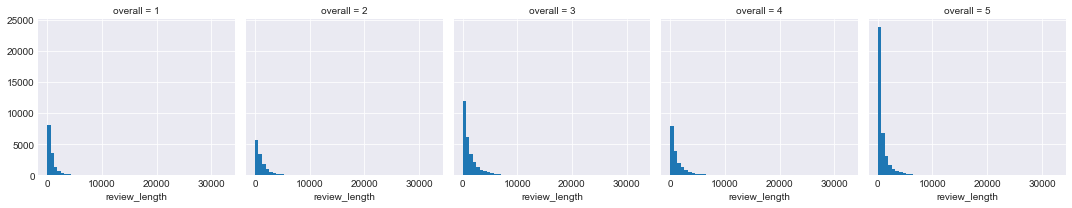

In [13]:
sns.set_style('darkgrid')
# Let's have a look and see if there is any relationship between 
# word length and reviews
g = sns.FacetGrid(data=gr_downsampled, col='overall')
g.map(plt.hist, 'review_length', bins=50);

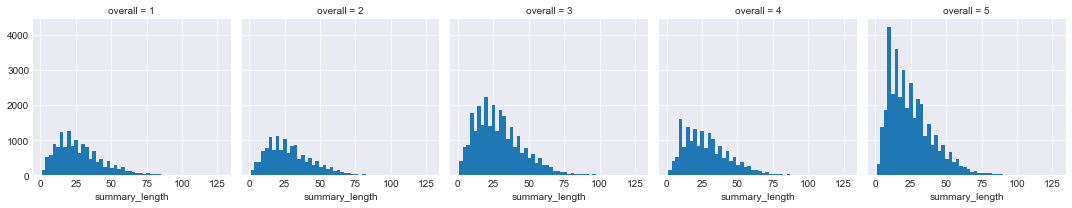

In [14]:
# What about summary
g = sns.FacetGrid(data=gr_downsampled, col='overall')
g.map(plt.hist, 'summary_length', bins=50);

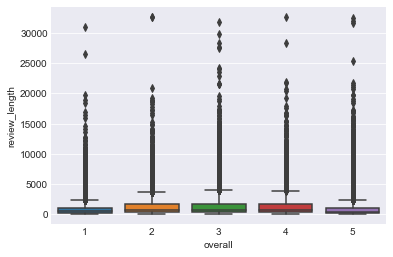

In [15]:
# Neither summary length nor review length have a normal distribution.
# Let's take a look and see how many outliers there are using a box plot. 
sns.boxplot(x='overall', y='review_length', data=gr_downsampled);

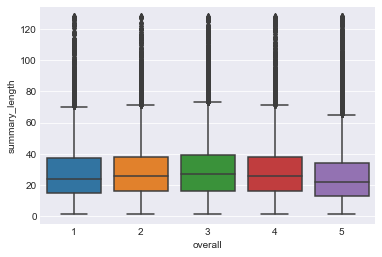

In [16]:
# Oh man, review length has a lot of outliers
# shows that the amount of words written can't really predict review rating.
sns.boxplot(x='overall', y='summary_length', data=gr_downsampled);

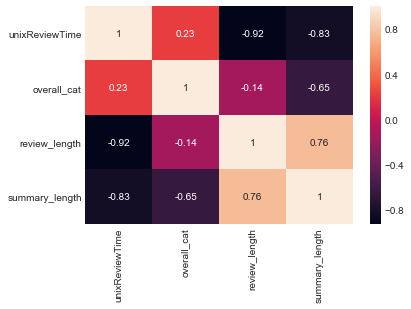

In [17]:
# Results are the same for the summary length, which i'm guessing
# is the title before the reviews.
# Lets use a heatmap next to see if there are any correlations. 
rating = gr_downsampled.groupby('overall').mean()

sns.heatmap(data=rating.corr(), annot=True);

In [8]:
# Write a function that removes puncutation, stopwords
# and return a list of words instead.

import string

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [15]:
# Vectorize the list of words 
from sklearn.feature_extraction.text import CountVectorizer

# Define the summary text so we can vectorize it
X = gr_downsampled['reviewText']

# Initialize and fit x.
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

len(bow_transformer.vocabulary_)

430602

In [22]:
# Store the data for future use.
%store bow_transformer

Stored 'bow_transformer' (CountVectorizer)


In [23]:
# Transform X into a sparse matrix.
X = bow_transformer.transform(X)

In [24]:
# Store X in for future use
%store X

Stored 'X' (csr_matrix)


In [25]:
# Train and test the data with 30% holdout.
y = gr_downsampled['overall_cat']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

# Model 1: Multinomial Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
#import and instantiate model

nb = MultinomialNB()

# Fit the model 
nb.fit(X_train, y_train)

x_pred = nb.predict(X_test)

In [27]:
# Evaluate model accuracy with cross val
from sklearn.model_selection import cross_val_score

cross_val_score(nb, X_test, y_test, cv=5)

array([0.76921948, 0.76228907, 0.7595011 , 0.76346295, 0.75770473])

In [28]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, x_pred))

[[13330  3691]
 [ 3766 13288]]


# Analysis 

- Multinomial Naive Bayes was used since it's more effective for text classification.
- Model is 75% accurate for the most part. 
- Model is probably only 75% accurate due to the confusing nature of 1-3 stars being converted to 0.
- Improve model accuracy by using tf-idf potentially. 
- Equal amounts of false positive and false negatives. 

# Model 2: SVM

In [36]:
# from sklearn.svm import SVC

# svm = SVC()

# # new parameters for this model
# svc_params = [{'C': [.00001,.0001,.001,.01,.1,1,
#                     10,100,1000,10000],
#               'gamma': [.00001,.0001,.001,.01,.1,1,10,25,100]}]

# # setting up the grid
# svc_grid = GridSearchCV(svm, svc_params, cv=5, verbose=1, n_jobs=-1)

# #Fit the grid
# svc_grid.fit(X, y)

# #return best parameters and best score
# print('Best parameters:')
# print(svc_grid.best_params_)
# print('Best Score:')
# print(svc_grid.best_score_)

# Model 3 Logistic Regression (Ridge Regularization)

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X, y)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 31.1min finished


Best parameters:
{'C': 0.01}
Best Score:
0.7903012801324153


In [34]:
# Implement parameter 
lr = LogisticRegression(C=.01, penalty='l1')

# Cross Validate the lr model. 
cross_val_score(lr, X, y, cv=5)

array([0.74315521, 0.768137  , 0.77192287, 0.77069026, 0.75092446])

# Analysis

Logistic model with the ridge regularization is performing at the same level as the multinomial nb which strengthens my idea that I should have added more features and not just relied on the review text. 

# Model 4: Random Forest Classifier

In [35]:
# Prepare random forest classifier
rfc = ensemble.RandomForestClassifier()

# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_features': [2, 4, 6, 8],
             'max_depth': [2, 4, 6]}

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X, y)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 90.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 101.0min finished


Best Parameter for data: {'max_depth': 6, 'max_features': 8, 'n_estimators': 1000}

Best Score for data: 0.6049021852054023


In [36]:
# Use the best parameters from previous GS-CV
# Took way too long so I don't want to do it again.
new_rfc = ensemble.RandomForestClassifier(n_estimators=1000, 
                                         max_features=8, max_depth=6)

# use cross val score
cross_val_score(new_rfc, X, y, cv=5)

array([0.58605511, 0.62555027, 0.61784645, 0.60252685, 0.57787463])

# Analysis 

The rfc model took the maximum amount of each parameter and was still only able to produce an accuracy of up to 60%.
The only explanation I can think of is that I didn't include enough features. The 'reviewText' may not have been enough data.